In [3]:
import os
os.chdir("/Users/chentahung/Desktop/git/mob-py/")
from pathlib import Path
import sys

repo_src = Path("src").resolve()
if str(repo_src) not in sys.path:
    sys.path.insert(0, str(repo_src))

# Plotting (inline in notebooks)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from MOBPY.binning.mob import MonotonicBinner
from MOBPY.core.constraints import BinningConstraints
from MOBPY.plot.csd_gcm import plot_csd_gcm
from MOBPY.plot.mob_plot import MOBPlot

In [5]:
def display_df(df, n=8, title=None):
    """Pretty display for notebooks; falls back to print if needed."""
    if title:
        print(f"\n=== {title} ===")
    try:
        from IPython.display import display
        display(df.head(n))
    except Exception:
        print(df.head(n))

In [6]:
df = pd.read_csv("data/german_data_credit_cat.csv")
df['default'] = df['default'] - 1
df["default"] = df["default"].clip(lower=0, upper=1).astype(int)

display_df(df, title="Raw sample (after default → {0,1})")
print("Target prevalence (y=1 rate):", df["default"].mean().round(4))
print("Rows:", len(df))


=== Raw sample (after default → {0,1}) ===


,Statusofexistingcheckingaccount,Durationinmonth,Credithistory,Purpose,Creditamount,Savingsaccountbonds,Presentemploymentsince,Installmentrate,Personalstatussex,Otherdebtors,...,Property,Age,installmentplans,Housing,existingcredits,Job,Numberofpeople,Telephone,foreignworker,default
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,0
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,1
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,0
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,0
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,1
5,A14,36,A32,A46,9055,A65,A73,2,A93,A101,...,A124,35,A143,A153,1,A172,2,A192,A201,0
6,A14,24,A32,A42,2835,A63,A75,3,A93,A101,...,A122,53,A143,A152,1,A173,1,A191,A201,0
7,A12,36,A32,A41,6948,A61,A73,2,A93,A101,...,A123,35,A143,A151,1,A174,1,A192,A201,0


Target prevalence (y=1 rate): 0.3
Rows: 1000


In [7]:
constraints = BinningConstraints(
    max_bins=6,
    min_bins=3,
    max_samples=None,    # you can set fractions like 0.4
    min_samples=0.05,    # fraction of clean samples per bin (resolved inside fit)
    min_positives=0.05,  # only used when y is binary
    initial_pvalue=0.40, # starting merge threshold (annealed internally if needed)
    maximize_bins=True,  # classic MOB behavior: don't exceed max_bins
)

binner = MonotonicBinner(
    df=df,
    x="Durationinmonth",
    y="default",
    metric="mean",    # MOB specializes PAVA for means; numeric y also supported
    sign="auto",      # infer monotonic direction from data
    strict=True,      # merge plateaus during PAVA
    constraints=constraints,
    exclude_values=None,  # e.g. [999] if you have special codes
    sort_kind="quicksort",
)

In [8]:
_ = binner.fit()

bins = binner.bins_()
summary = binner.summary_()

display_df(bins, title="Clean numeric bins")
display_df(summary, title="Full summary (includes Missing/Excluded rows if present)")

print("\nResolved sign:", getattr(binner, "resolved_sign_", None))
print("Number of clean bins:", len(bins))



=== Clean numeric bins ===


,left,right,n,sum,mean,std,min,max
0,4.0,9.0,94,10.0,0.106383,0.309980,0.0,1.0
1,9.0,12.0,86,17.0,0.197674,0.400581,0.0,1.0
2,12.0,16.0,251,62.0,0.247012,0.432135,0.0,1.0
3,16.0,36.0,399,129.0,0.323308,0.468327,0.0,1.0
4,36.0,45.0,100,42.0,0.420000,0.496045,0.0,1.0
5,45.0,inf,70,40.0,0.571429,0.498445,0.0,1.0



=== Full summary (includes Missing/Excluded rows if present) ===


,left,right,interval,nsamples,bads,goods,bad_rate,woe,iv_grp
0,4.0,9.0,"(4, 9)",94,10.0,84.0,0.106383,1.239030,0.106168
1,9.0,12.0,"[9, 12)",86,17.0,69.0,0.197674,0.532779,0.021833
2,12.0,16.0,"[12, 16)",251,62.0,189.0,0.247012,0.262876,0.016439
3,16.0,36.0,"[16, 36)",399,129.0,270.0,0.323308,-0.109755,0.004917
4,36.0,45.0,"[36, 45)",100,42.0,58.0,0.420000,-0.526824,0.030513
5,45.0,inf,"[45, inf)",70,40.0,30.0,0.571429,-1.129922,0.103088



Resolved sign: +
Number of clean bins: 6


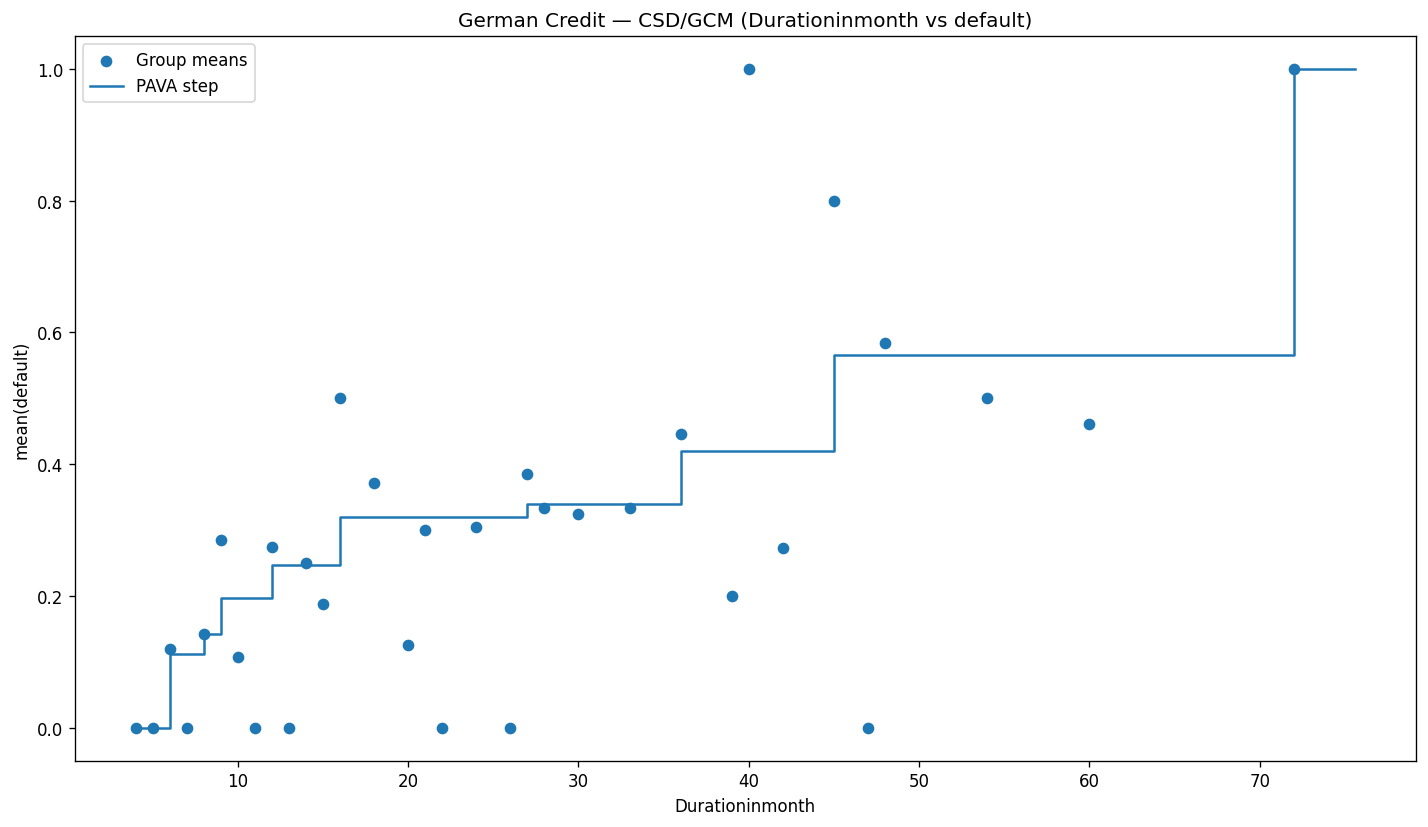

Saved CSD/GCM plot → /Users/chentahung/Desktop/git/mob-py/doc/newMob/german_csd_gcm.png


In [11]:
fig_path = "/Users/chentahung/Desktop/git/mob-py/doc/newMob/german_csd_gcm.png"

plot_csd_gcm(
    groups_df=binner._pava.groups_,
    blocks=binner._pava.export_blocks(as_dict=True),
    x_name=binner.x,
    y_name=binner.y,
    title="German Credit — CSD/GCM (Durationinmonth vs default)",
    savepath=str(fig_path),
)

from IPython.display import Image, display
display(Image(filename=str(fig_path)))
print(f"Saved CSD/GCM plot → {fig_path}")

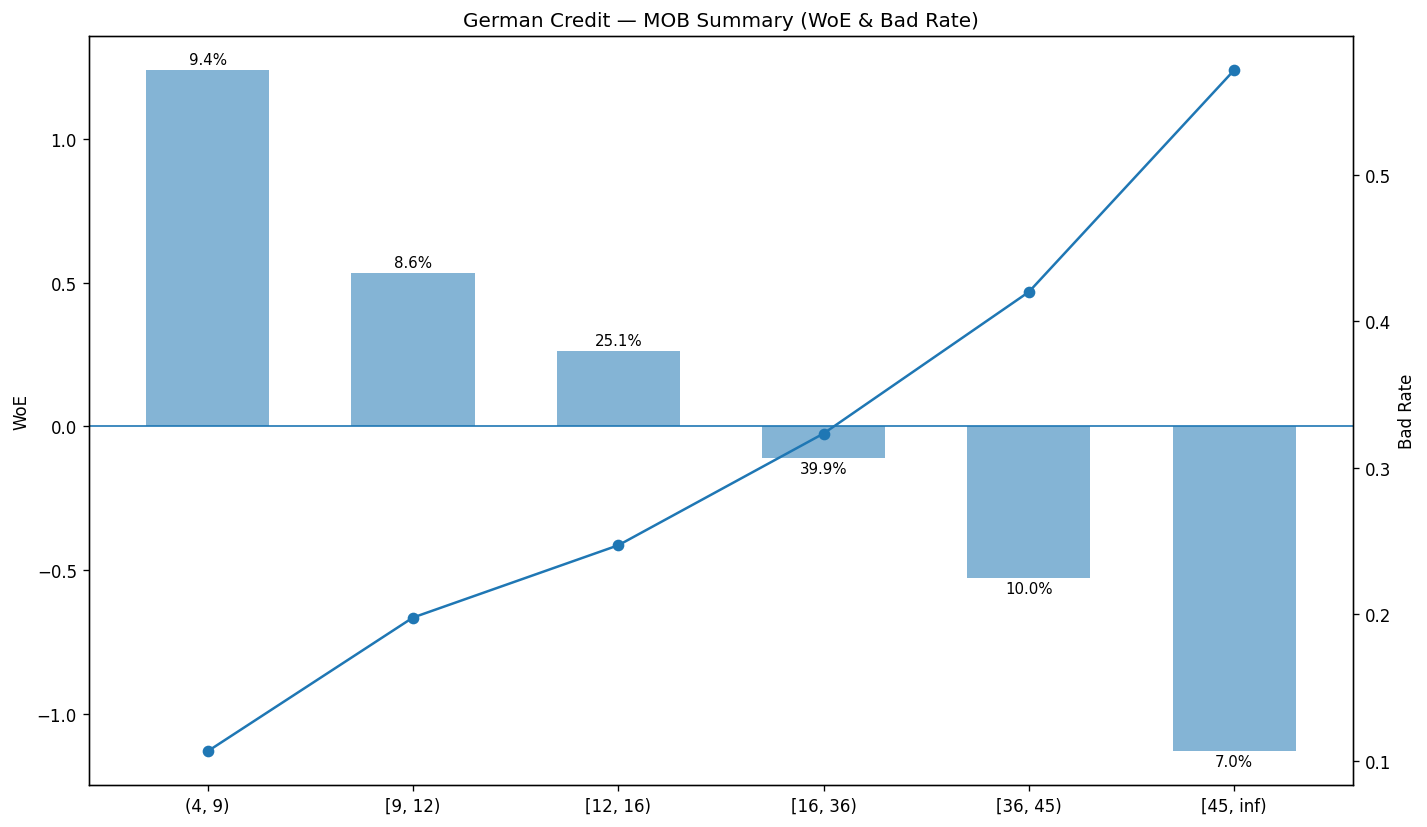

Saved MOB summary plot → /Users/chentahung/Desktop/git/mob-py/doc/newMob/german_mob_summary.png


In [12]:
fig2_path = "/Users/chentahung/Desktop/git/mob-py/doc/newMob/german_mob_summary.png"
# MOBPlot expects the binary summary table produced by binner.summary_()
MOBPlot.plot_bins_summary(
    summary=summary,
    title="German Credit — MOB Summary (WoE & Bad Rate)",
    savepath=str(fig2_path),
)

from IPython.display import Image, display
display(Image(filename=str(fig2_path)))
print(f"Saved MOB summary plot → {fig2_path}")

In [13]:
sample_x = pd.Series([6, 12, 24, 30, np.nan, 999], name="Durationinmonth")

print("Assign as interval label:")
print(binner.transform(sample_x, assign="interval").to_string(index=False))

print("\nAssign left edges:")
print(binner.transform(sample_x, assign="left").to_string(index=False))

print("\nAssign right edges:")
print(binner.transform(sample_x, assign="right").to_string(index=False))


Assign as interval label:
   [4, 9)
 [12, 16)
 [16, 36)
 [16, 36)
  Missing
[45, inf)

Assign left edges:
    4.0
   12.0
   16.0
   16.0
Missing
   45.0

Assign right edges:
    9.0
   16.0
   36.0
   36.0
Missing
    inf


In [14]:
# If you want to try a stricter min_samples or fewer bins:
alt = MonotonicBinner(
    df=df, x="Durationinmonth", y="default",
    metric="mean", sign="auto", strict=True,
    constraints=BinningConstraints(
        max_bins=5, min_bins=3, min_samples=0.10, min_positives=0.05, initial_pvalue=0.4, maximize_bins=True
    )
).fit()

print("Alt bins count:", len(alt.bins_()))
display_df(alt.bins_(), title="Alt config — bins")


Alt bins count: 3

=== Alt config — bins ===


,left,right,n,sum,mean,std,min,max
0,4.0,16.0,431,89.0,0.206497,0.405261,0.0,1.0
1,16.0,36.0,399,129.0,0.323308,0.468327,0.0,1.0
2,36.0,inf,170,82.0,0.482353,0.501165,0.0,1.0
